In [15]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from mne.preprocessing import ICA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

import itertools
from mne.viz import tight_layout

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [16]:
def SubjFolderSearch(path):
    subjFolders = os.listdir(path)
    AllFolders = []
    for i in subjFolders:
        if '.DS_Store' not in i:
            AllFolders.append(i)
    
    AllFolders_dict = {}
    for eachFolder in AllFolders:
        eachFolderPath = os.path.join(path,eachFolder)
        folderContents = os.listdir(eachFolderPath)
        AllFolders_dict[eachFolder] = [file for file in folderContents if '.set' in file]
       
        
    return AllFolders_dict

In [17]:
#seach all folders and the set files in each folder
path = '/Volumes/flash32/EEGLAB'
AllSetFiles = SubjFolderSearch(path)
print(AllSetFiles)

{'SA20140304': ['20140304_1418.set', '20140304_1614.set'], 'SA20140306': ['20140306_1133.set', '20140306_1338.set']}


In [18]:
# read file
np.random.seed(42)
folder_keys = list(AllSetFiles.keys())      
folder = os.path.join(path,folder_keys[1])

set_file = os.path.join(folder, AllSetFiles[folder_keys[1]][1])
raw = mne.io.read_raw_eeglab(set_file, preload=True, verbose = True)
raw_copy = raw.copy().crop(10,300)

Reading /Volumes/flash32/EEGLAB/SA20140306/20140306_1338.fdt
Reading 0 ... 796266  =      0.000 ...  1555.207 secs...


In [19]:
events = mne.find_events(raw_copy,min_duration=1/raw.info['sfreq'], shortest_event=1)


1072 events found
Event IDs: [  1   2   3   4   5   7   8   9  10  11  13  14  19  20  21  31 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 157 158 159
 160 161 162 163 164]


In [20]:
event_id = {'TRIALSTART':31,
            'LEFTBUTTON':131, # only one button code is sent,
            'RIGHTBUTTON':132, # but it may appear before f2 stim if fast response
            'CONGRUENT':133,# only one congruity code is sent
            'INCONGRUENT':134,
            'CORRECT':129, # only one accuracy code is sent
            #'INCORRECT':130,
            #target
            'BABY_T':135, 
            'BELL_T':136,
            'BIRD_T':137, 
            'BURP_T':138, 
            'DOG_T':139, 
            'DRUM_T':140, 
            'KNOCK_T':141, 
            'LAUGH_T':142, 
            'PHONE_T':143, 
            'TRAIN_T':144,  
            'WATER_T':145,
            #flanker
            #'BABY_F':155, 
            #'BELL_F':156,
            'BIRD_F':157, 
            'BURP_F':158, 
            'DOG_F':159, 
            'DRUM_F':160, 
            'KNOCK_F':161, 
            'LAUGH_F':162, 
            'PHONE_F':163, 
            'TRAIN_F':164,  
            #'WATER_F':165,
            }

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1691 samples (3.303 sec) selected
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-21-1c6233f3ec9d>:8: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epoch.average().plot()


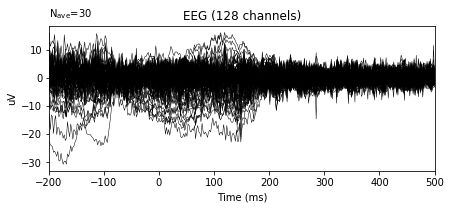

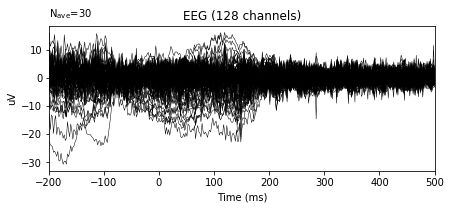

In [21]:
raw_copy.filter(1., None, n_jobs=1, fir_design='firwin')
tmin, tmax = -0.1, 0.3
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
epoch = mne.Epochs(raw_copy,events,event_id=[139,159],preload=True,picks=picks, baseline=None,
                    verbose=False)

epoch.average().plot()

In [22]:
X = epoch.get_data()
array_events=epoch.events[:,-1]

array_data = X[:,-1]  #data needs to be in 2 dimensions. n_channels x n_samples

#init pca and fit to data
pca = UnsupervisedSpatialFilter(PCA(), average=False)
pca_data = pca.fit_transform(X)
array_events

array([159, 139, 159, 159, 139, 159, 159, 139, 159, 139, 159, 139, 159,
       159, 159, 159, 139, 159, 159, 139, 159, 159, 139, 159, 139, 159,
       139, 159, 159, 159])

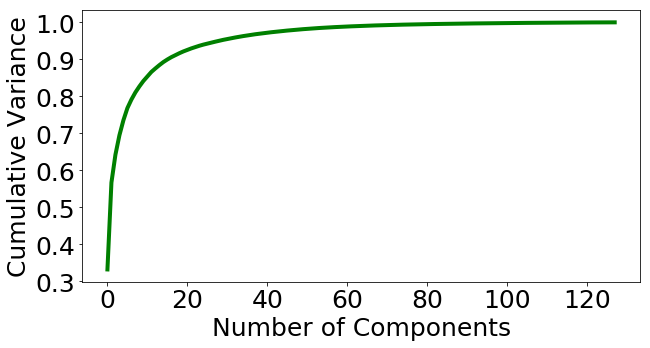

In [23]:
comp_variance = np.cumsum(pca.estimator.explained_variance_ratio_)
plt.plot(comp_variance, linewidth = 4.0, color = 'g')
plt.xlabel('Number of Components', fontsize = 25)
plt.ylabel('Cumulative Variance', fontsize = 25);
plt.xticks(fontsize = 25);
plt.yticks(fontsize = 25);


In [24]:
n_components = np.argwhere(comp_variance > .95)[0]
print(n_components)

[28]


In [25]:
comp_variance[28]

0.9503360687214373

In [26]:
pca = UnsupervisedSpatialFilter(PCA(28), average=False)
pca_data = pca.fit_transform(X)


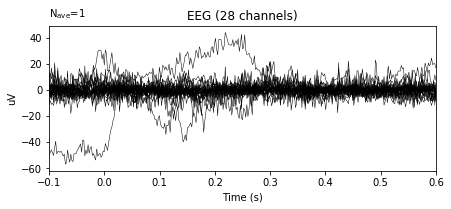

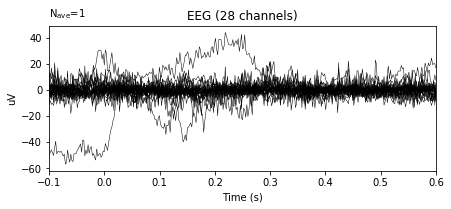

In [27]:
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(28, epoch.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA", time_unit='s')

In [29]:
#logic regres classification
logreg = LogisticRegression()

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)

#fit with cross validation on original data
scores = []
preds = np.empty(len(array_events))
for train, test, in cv.split(array_data, array_events):
    logreg.fit(array_data[train], array_events[train])
    preds[test] = logreg.predict(array_data[test])
    scores.append(logreg.score(array_data[test],array_events[test]))

In [30]:
print("mean classification score", np.mean(scores))
target_names = ['dog_t', 'dog_f']
report = classification_report(array_events, preds, target_names=target_names)
print(report)


mean classification score 0.6666666666666667
             precision    recall  f1-score   support

      dog_t       0.00      0.00      0.00        10
      dog_f       0.67      1.00      0.80        20

avg / total       0.44      0.67      0.53        30



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


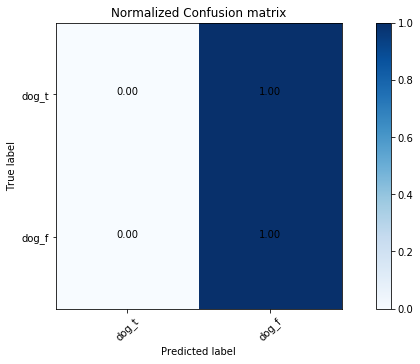

In [31]:
# Normalized confusion matrix
cm = confusion_matrix(array_events, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fmt = '.2f'
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j],fmt),
                 horizontalalignment="center",
                 color="black")
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
#LDA classification
LDA=LDA()

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)

#fit with cross validation on original data
scores = []
#preds = np.empty(len(array_events))
for train, test, in cv.split(array_data, array_events):
    LDA.fit(array_data[train], array_events[train])
    #preds[test] = LDA.predict(XX[test])
    scores.append(LDA.score(array_data[test],array_events[test]))

TypeError: 'LinearDiscriminantAnalysis' object is not callable

In [38]:
print("mean classification score LDA: ", np.mean(scores))

mean classification score LDA:  0.4999999999999999


In [39]:
# classifiy with pca and logreg


pca_scores = []
X_pca = pca_data[:,-1]
for train, test, in cv.split(pca_data, array_events):
    logreg.fit(X_pca[train], array_events[train])
#     preds[test] = clf.predict(X[test])
    scores.append(logreg.score(X_pca[test],array_events[test]))


In [40]:
print("pca with 28 compoentns mean classification score", np.mean(scores))

pca with 28 compoentns mean classification score 0.5833333333333333


In [41]:
# classifiy with pca and LDA
pca_scores = []
X_pca = pca_data[:,-1]
for train, test, in cv.split(pca_data, array_events):
    LDA.fit(X_pca[train],array_events[train])
#     preds[test] = clf.predict(X[test])
    scores.append(LDA.score(X_pca[test],array_events[test]))


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [42]:
print("pca with 28 compoentns mean classification score", np.mean(scores))

pca with 28 compoentns mean classification score 0.6


In [43]:
epoch.info

<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Lm, LE1, Nasium, LE3, LD2, LD5, LC3, LC6, LB1, ...
    chs : list | 128 items (EEG: 128)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 128 items
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 256.0 Hz
    nchan : int | 128
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneT

In [1]:
#attempt Plot ICA components
method = 'fastica'

# Choose other parameters

decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23

In [575]:
ica = ICA(n_pca_components=28,max_pca_components=28, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


In [578]:
picks_meg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
ica.fit(raw_copy, picks=picks_meg, decim=decim)
print(ica)

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Using all PCA components: 28
Fitting ICA took 5.0s.
<ICA  |  raw data decomposition, fit (fastica): 49494 samples, 28 components, channels used: "eeg">


In [579]:
ica.plot_components()

Fitted sphere radius:         0.0 mm
Origin head coordinates:      0.0 0.0 0.0 mm
Origin device coordinates:    0.0 0.0 0.0 mm


TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0,0.5,'Mean band Amplitude')

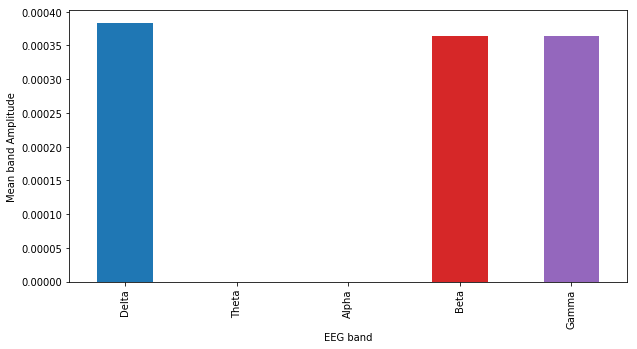

In [45]:
import numpy as np

fs = 512                                # Sampling rate (512 Hz)
data = pca_data  # 2 sec of data b/w 0.0-100.0

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")